# Structural Defects Project
SDNET2018 is an annotated image dataset that contains over 56,000 images of cracked and non-cracked concrete bridge decks, walls, and pavements. The dataset includes cracks as narrow as 0.06 mm and as wide as 25 mm. The dataset also includes images with a variety of obstructions, including shadows, surface roughness, scaling, edges, holes, and background debris.

The goal of this project is to build a neural network to assist with structural health monitoring. I want to be able to train a model to identify whether or not there are cracks in the concrete.

2023-10-13 04:08:35.076340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 04:08:35.076370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 04:08:35.076386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


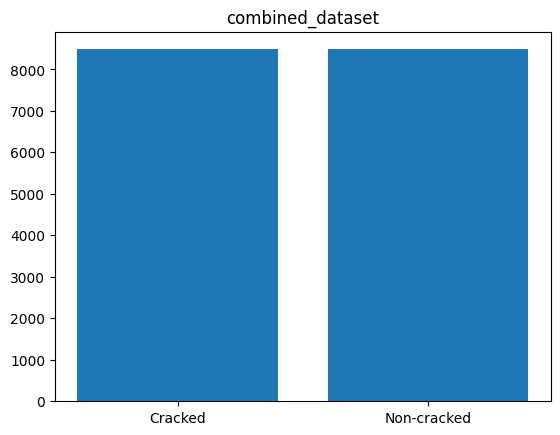

In [1]:
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential


# Constants
data_path = '../combined_dataset'
batch_size = 32
target_size = (256, 256)
#epochs = 1

def plot_counts(directory):
    cracked_count = len(os.listdir(os.path.join(directory, 'Cracked')))
    non_cracked_count = len(os.listdir(os.path.join(directory, 'Non-cracked')))
    
    plt.bar(['Cracked', 'Non-cracked'], [cracked_count, non_cracked_count])
    plt.title(directory.split('/')[-1])
    plt.show()

plot_counts(data_path)

# Data Augmentation
Data augmentation is a technique used to artificially increase the size of your training dataset. The idea is that by applying random but realistic modifications to the input data, the model is exposed to more varied data and is less likely to overfit to the training data. Common augmentations include rotations, translations, zooms, and horizontal flips.

ImageDataGenerator is a utility in TensorFlow's Keras API designed to automate the process of data augmentation for image data. It generates batches of augmented/normalized data from your image dataset on-the-fly while your model is still in the training process. This is advantageous as it saves storage by not having to save the augmented images on disk, and the random augmentations mean the model sees slightly different images each epoch.

In [2]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)


In [3]:
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 13576 images belonging to 2 classes.
Found 3392 images belonging to 2 classes.


# Initializing the Model
In this project, I am taking advantage of transfer learning. I'm using ResNet50V2 which has already been pre-trained on ImageNet and understands a lot about various features in images (like edges, textures, and more complex patterns) due to its training on a large dataset. I freeze the pre-trained weights and add custom layer on top so that the model can use the knowledge that it's already gained from ImageNet. I am only training the final layher to be able to classify cracked vs non-cracked. 

ResNet, which stands for Residual Network, is a class of deep neural networks popular for image classification and other computer vision tasks. They are particularly well-known for their ability to be trained very deep – often with hundreds of layers – without suffering from the vanishing gradient problem, thanks to the introduction of residual connections.

In [10]:
base_model = ResNet50V2(include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [16]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='softmax')
])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import MaxPooling2D,Conv2D,AveragePooling2D

model=Sequential()
model.add(Conv2D(6,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(AveragePooling2D(2,2))
model.add(Conv2D(18,(3,3),activation='relu'))
model.add(AveragePooling2D(2,2))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(AveragePooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(AveragePooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 average_pooling2d (Average  (None, 127, 127, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 18)      990       
                                                                 
 average_pooling2d_1 (Avera  (None, 62, 62, 18)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        5216      
                                                                 
 average_pooling2d_2 (Avera  (None, 30, 30, 32)       

# Deciding on a performance metric
Given the imbalanced nature of the dataset and the importance of correctly identifying cracks, you might want to consider the following metrics:

<b> Precision (Positive Predictive Value): </b>

Precision is the number of true positives divided by the sum of true positives and false positives. It essentially answers the question: "Out of all the images predicted as 'Cracked', how many were actually 'Cracked'?"
A high precision indicates that an algorithm returned substantially more relevant results than irrelevant ones.


<b> Recall (Sensitivity, True Positive Rate): </b>

Recall is the number of true positives divided by the sum of true positives and false negatives. It answers the question: "Out of all the actual 'Cracked' images, how many did we correctly predict as 'Cracked'?"
In this context, a high recall is crucial since it would mean that most of the actual cracks are being detected.

<b> F1 Score: </b>

The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall and can be a better measure than accuracy, especially on imbalanced datasets.

<b> Area Under the Receiver Operating Characteristic Curve (AUC-ROC): </b>

ROC is a probability curve, and AUC represents the degree or measure of separability. It indicates how much the model is capable of distinguishing between the classes.
An excellent model has an AUC near 1, indicating it has a good measure of separability. A poor model has an AUC near 0, indicating it has the worst measure of separability.

# Instantiating the Model

In [24]:
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC(name='auc')])
#print(len(base_model.non_trainable_weights))
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [25]:
epochs = 3
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/3
425/425 [==============================] - 116s 268ms/step - loss: 0.6937 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.5056
Epoch 2/3
425/425 [==============================] - 116s 273ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6930 - val_accuracy: 0.4997
Epoch 3/3
425/425 [==============================] - 117s 276ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5000


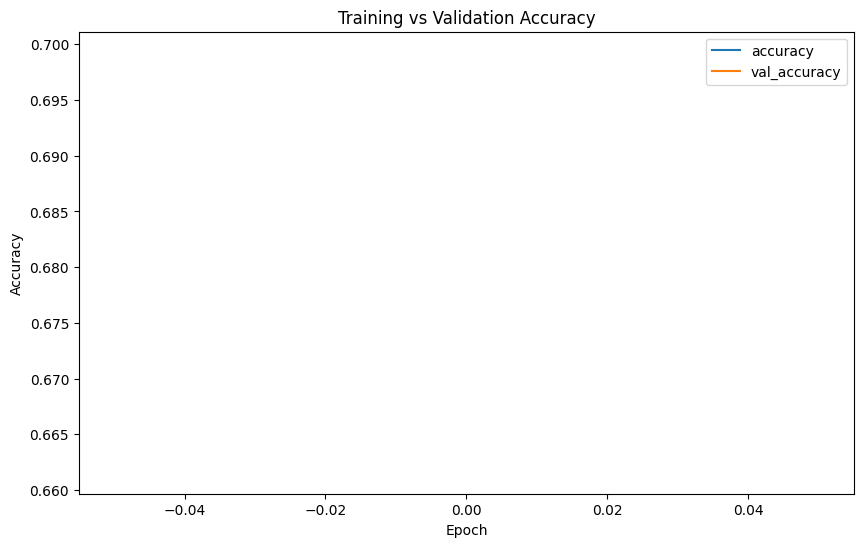

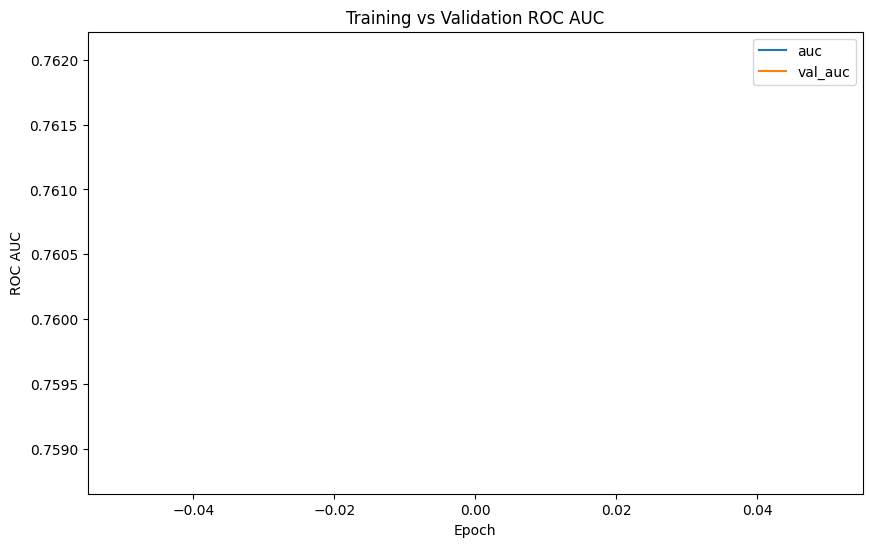

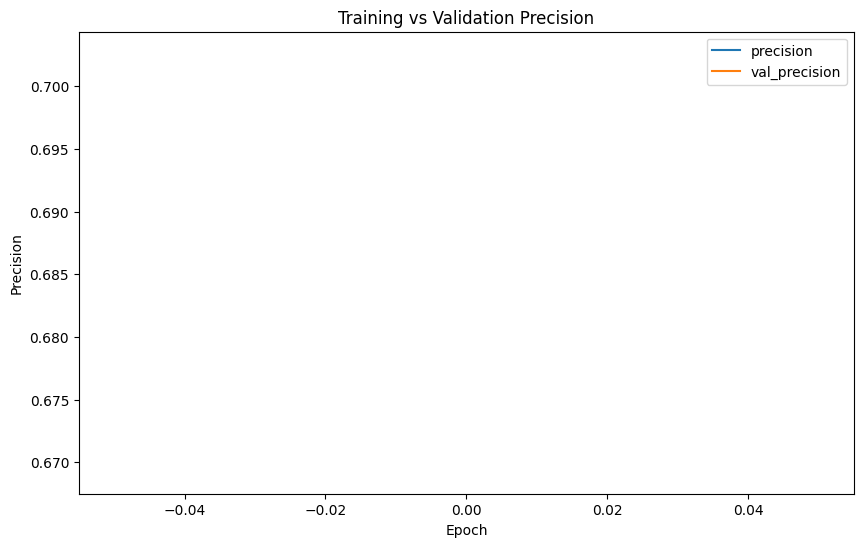

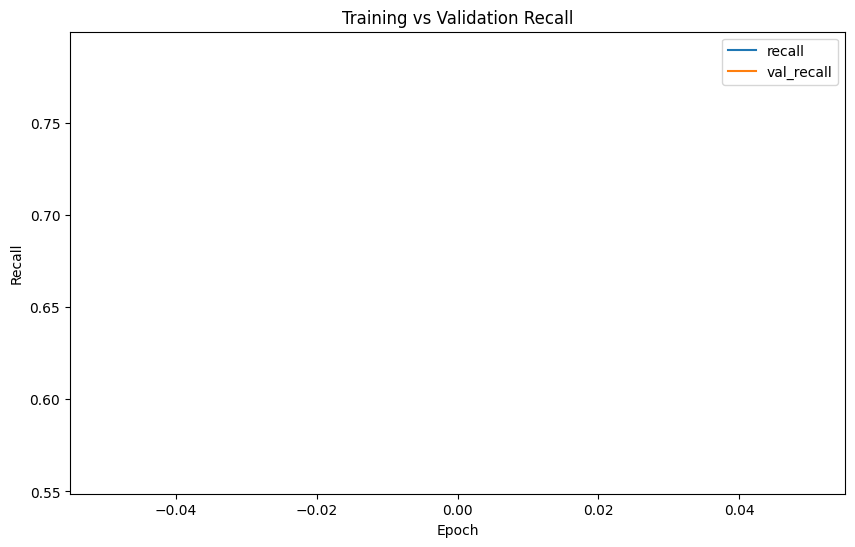

In [9]:
import matplotlib.pyplot as plt

# Plotting function
def plot_history(history, metric, val_metric, title, ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history[val_metric], label=val_metric)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Accuracy
plot_history(history, 'accuracy', 'val_accuracy', 'Training vs Validation Accuracy', 'Accuracy')

# ROC AUC
plot_history(history, 'auc', 'val_auc', 'Training vs Validation ROC AUC', 'ROC AUC')

# Precision
plot_history(history, 'precision', 'val_precision', 'Training vs Validation Precision', 'Precision')

# Recall
plot_history(history, 'recall', 'val_recall', 'Training vs Validation Recall', 'Recall')

In [ ]:
# I should try to implement some ideas from here: https://www.kaggle.com/code/rohith3330/cnn-excersice-20bd1a6618
# actually, I was looking at the other notebooks, and they aren't accounting for the fact that this is an imbalanced classification task.
# they are not handling the imbalanced, and so the model is just learning to predict the negative class the entire time